In [1]:
import sys,os
sys.path.append("../")

import pandas as pd
import numpy as np
import pickle

from scipy.stats import entropy
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances  
from sklearn.metrics import mutual_info_score

import matplotlib.pyplot as plt
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import seaborn as sns




## Reading the change object and clustering.

In [2]:
article_name = "E_(mathematical_constant)"
content_dir = "../data/content/"
filename = article_name + ".h5"
filepath = os.path.join(content_dir, filename)
with pd.HDFStore(filepath, 'r') as store:
    all_rev = store.get("all_tokens")
token_string_df = all_rev.set_index("token_id")["str"]

In [3]:
change_object_dir =  "../data/change objects/"

change_object_file_name = f"{article_name}_vec.npz"
filename =  f"{article_name}_change.h5"

change_object_file = os.path.join(change_object_dir, filename)


change_vector_dir = "../data/change_vector/"
change_vec_filename = f"{article_name}.npz"
change_vector_file = os.path.join(change_vector_dir, change_vec_filename)

content_dir = "../data/content/"
len_file = article_name + "_rev_len.h5"
len_file_path = os.path.join(content_dir, len_file)


In [4]:
%%time
if os.path.exists(change_object_file):
    with pd.HDFStore(change_object_file, 'r') as store:
        change_object_dataframe = store.get("data")
else:
    print("file do not exist")

change_object_dataframe["edit_tokens"] = change_object_dataframe["ins_tokens"] + change_object_dataframe["del_tokens"]
change_object_dataframe["edit_tokens"] = change_object_dataframe["edit_tokens"].apply(lambda x:  tuple(token_string_df[np.array(x)].tolist()))

CPU times: user 11.2 s, sys: 484 ms, total: 11.7 s
Wall time: 11.7 s


In [5]:
 
rev_len_df = pd.read_hdf(len_file_path, key = "rev_len")

vectors ={}
with open(change_vector_file, "rb") as file:
    
    arrays_dict = np.load(file)
    
    vectors["clean_notweighted_4"] = arrays_dict["4_clean_not_weighted"]
    vectors["clean_notweighted_10"] = arrays_dict["10_clean_not_weighted"] 

## Finding relative positions of change object

In [6]:
change_object_dataframe = change_object_dataframe.reset_index().set_index('from revision id')
change_object_dataframe = change_object_dataframe.join(rev_len_df.set_index("rev_id"))
change_object_dataframe.index.name = "from revision id"

change_object_dataframe["relative_position"] =(change_object_dataframe["left_neigh"]+1)/(change_object_dataframe["length"]).round(3)

change_object_dataframe = change_object_dataframe.reset_index().set_index(["from revision id","timestamp", "level_5"])
# rel_pos = change_object_dataframe["relative_position"]
# rel_pos_r = rel_pos.round(4)
# rel_pos_r.size
change_object_dataframe = change_object_dataframe[["edit_tokens", "relative_position"]]


change_object_dataframe.shape

(14311, 2)

In [7]:
def gini(array):
    # Number of array elements:
    n = array.shape[0]
    index = np.arange(1, n+1)
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [8]:
def evaluate(change_object_dataframe, clusters, evaluation_df, column_names):
    
    change_object_dataframe["cluster"] = pd.Series(clusters, index= change_object_dataframe.index)
    
    stats_series = pd.Series(index=column_names)
    
    non_negative_cluster_mask = clusters != -1
    non_neg_cluster_df = change_object_dataframe.loc[non_negative_cluster_mask, :]

    stats_series["no_of_outliers"]  = np.count_nonzero(~non_negative_cluster_mask)
    stats_series["no_of_clusters"] = np.unique(clusters[non_negative_cluster_mask]).size

    rank_by_size = non_neg_cluster_df.groupby("cluster").size().sort_values(ascending=True)

    relative_postion_std = non_neg_cluster_df.groupby("cluster")["relative_position"].std()
#     stats_series["relative_position_std_max"] = relative_postion_std.max()
#     stats_series["relative_position_std_min"] = relative_postion_std.min()
#     stats_series["relative_position_std_median"] = relative_postion_std.median()
#     stats_series["relative_position_std_skewness"] = relative_postion_std.skew()
#     stats_series["relative_position_std_kurtosis"] = relative_postion_std.kurt()

    stats_series["relative_position_std_less_than_.1"] = np.count_nonzero(relative_postion_std <.1)
    

    size_stats = rank_by_size.describe()
    if rank_by_size.shape[0] > 1:
        stats_series["top2_ratio"] = rank_by_size.iloc[1]/rank_by_size.iloc[0]
    else:
        stats_series["top2_ratio"] = 0
    stats_series["max_cluster_size"] = size_stats["max"]
    stats_series["min_cluster_size"] = size_stats["min"]
    stats_series["mean_cluster_size"] = size_stats["mean"]
    stats_series["median_cluster_size"] = size_stats["50%"]
    stats_series["inter_quartile_range_cluster_size"] = size_stats["75%"] - size_stats["25%"]

    stats_series["variance_cluster_size"] = rank_by_size.var()
    stats_series["standard_deviation_cluster_size"] = size_stats["std"]
    stats_series["skewness_cluster_size"] = rank_by_size.skew()
    stats_series["kurtosis_cluster_size"] = rank_by_size.kurt()
    
    cluster_sizes = non_neg_cluster_df.groupby("cluster").size().values
    cluster_sizes = cluster_sizes / cluster_sizes.sum()
    
    token_entropy_clusters = non_neg_cluster_df.groupby("cluster")["edit_tokens"].apply(
        lambda token_tuples: entropy(pd.Series(
            [token for token_tuple in token_tuples.tolist() for token in token_tuple]
        ).value_counts().values))
    stats_series["token_entropy"] = (cluster_sizes * token_entropy_clusters).sum()
    stats_series["avg_token_entropy"] =  token_entropy_clusters.mean()


    
    position_entropy_clusters = non_neg_cluster_df.groupby("cluster")["relative_position"].apply(
        lambda x: entropy(x.value_counts().values))
    stats_series["position_entropy"] = (cluster_sizes * position_entropy_clusters).sum()
    stats_series["avg_position_entropy"] =  position_entropy_clusters.mean()


 
    stats_series["gini"] = gini(rank_by_size.values)
    
    change_object_dataframe  = change_object_dataframe.drop("cluster",axis=1)
    
    return stats_series

# Evaluation of DBSCAN


Following is the description of Pre evaluation metric 


### represents the noise in the tokens in the clusters. 
* __"token_entropy"__: Sum of Shanon entropies of cluster tokens weighted by cluster sizes. Weighting is done to give more weight to bigger clusters. 
As its easier to have smaller cluster with relatively less kind of data hence high shannon entropy

### These represent ability of DBSCAN to find clusters.
* "no_of_outliers": Total number of data points which were not put in any clusters by dbscan.
* "no_of_clusters": Total number of clusters found by the algorithm.

### These represents stability of clusters with respect to relative position of change object in its revision.
* __"position_entropy"__: Sum of Shanon entropies of relative position in a cluster weighted by cluster sizes. Weighting is done to give more weight to bigger clusters. As its easier to have smaller cluster with relatively less kind of data hence high shannon entropy.
* "relative_position_std_less_than_.1": Counts the clusters where relative position standard deviation is less thatn 0.1

### These represents  discriptive statistics representing distribution  of clusters sizes.
* "max_cluster_size": Gives size of points inside biggest clusters.
* "min_cluster_size": Gives size of points inside samllest clusters.
* "mean_cluster_size": Gives mean cluster size.
* "skewness_cluster_size": 
* "kurtosis_cluster_size":
* "median_cluster_size": Gives median cluster size.
* "inter_quartile_range_cluster_size": Gives inter quartile range of cluster size. i.e. Difference between 1st quartile and 3rd quartile. 
* "variance_cluster_size": Variance in cluster size values across all clusters.
* "standard_deviation_cluster_size": Square root of clusters. Easy to interpret as is direct representation of dispersion in distribution.

#### These Two represent distribution of cluster sizes
* "top2_ratio": Ratio of second biggest cluster size with the biggest cluster size
* "gini": Gini coeffecient of cluster size distribution among clusters.


---
---
__Shanon Entropy__ : Shanon's entropy formally $\displaystyle\sum_{i}p_i\log{p_i}$ where $p_i$ is probability of ith kind of data.
This value is zero when infromation is pure and it tends towards infinity as noise of type of data starts increasing.
Similar idea is used in decision tree to find pure classification.

__Total Entropy__: While calucalting total entropy we do not take oridinary sum because smaller clusters will tend to have less noise. 



In [9]:
change_object_dataframe["relative_position"] = (change_object_dataframe["relative_position"] - change_object_dataframe["relative_position"].mean())/change_object_dataframe["relative_position"].std()
dbscan_params =[
    { "eps": 0.25, "min_samples": 5 },
    { "eps": 0.5, "min_samples": 5 },
    { "eps": 0.55, "min_samples": 5 },
    { "eps": 0.6, "min_samples": 5 },
    { "eps": 0.65, "min_samples": 5 },
    { "eps": 0.7, "min_samples": 5 },
    { "eps": 0.75, "min_samples": 5 },
    { "eps": 0.8, "min_samples": 5 },
    { "eps": 0.85, "min_samples": 5 },
    { "eps": 0.9, "min_samples": 5 },
    { "eps": 0.95, "min_samples": 5 },
    { "eps": 1, "min_samples": 5 },
]

# vector_names = ["clean_weighted_4", "clean_weighted_10", "clean_weighted_30",
#                 "clean_notweighted_4", "clean_notweighted_10", "clean_notweighted_30",
#                 "notclean_weighted_4", "notclean_weighted_10", "notclean_weighted_30",
#                 "notclean_notweighted_4", "notclean_notweighted_10",  "notclean_notweighted_30"  
#                ]

vector_names = [ "clean_notweighted_4", "clean_notweighted_10"]
column_names = ["top2_ratio","no_of_outliers", "no_of_clusters",

                "relative_position_std_less_than_.1",
                "max_cluster_size", "min_cluster_size", "mean_cluster_size",
                "skewness_cluster_size", "kurtosis_cluster_size",
                 "median_cluster_size",  "inter_quartile_range_cluster_size",
                "variance_cluster_size", "standard_deviation_cluster_size",
                "gini", "token_entropy", "position_entropy",
               "avg_position_entropy", "avg_token_entropy"]
idx = pd.MultiIndex.from_product([vector_names, 
                                  [ param["eps"] for param in dbscan_params]],
                             names=['types', 'eps'])
evaluation_df = pd.DataFrame(index=idx, columns=column_names)
# sns.distplot(change_object_dataframe["relative_position"])



In [10]:
%%time
for cluster_by in vector_names:
    distances = pairwise_distances(vectors[cluster_by])
    for dbscan_param in dbscan_params:
        clusters = DBSCAN(**dbscan_param, metric="precomputed").fit(distances)
        evaluation_df.loc[(cluster_by,dbscan_param["eps"]),:] = evaluate(
            change_object_dataframe, clusters.labels_, evaluation_df, column_names)

CPU times: user 1min 50s, sys: 55.9 s, total: 2min 46s
Wall time: 1min 57s


In [11]:
split_df = evaluation_df.reset_index()["types"].str.split("_", expand = True)[[0,1,2]]
split_df.index = evaluation_df.index
evaluation_df[["cleaned", "weighted", "neighbour_size"]] = split_df
# evaluation_df = evaluation_df.reset_index().set_index(["cleaned", "weighing", "neighbour"])
evaluation_df=evaluation_df.reset_index().set_index(["cleaned", "weighted", "neighbour_size","eps"])
evaluation_df= evaluation_df.loc["clean","notweighted"]

In [12]:
# pre_evaluation_dir = "../data/pre_evaluation/"
# file_name = f"{article_name}.csv"
# full_file_path = os.path.join(pre_evaluation_dir, file_name)
# evaluation_df.to_csv(full_file_path)


In [13]:
evaluation_df.head(3)

types top2_ratio no_of_outliers  \
neighbour_size eps                                                   
4              0.25  clean_notweighted_4          1           6846   
               0.50  clean_notweighted_4          1           6846   
               0.55  clean_notweighted_4          1           6846   

                    no_of_clusters relative_position_std_less_than_.1  \
neighbour_size eps                                                      
4              0.25            324                                123   
               0.50            324                                123   
               0.55            324                                123   

                    max_cluster_size min_cluster_size mean_cluster_size  \
neighbour_size eps                                                        
4              0.25             2706                5           23.0401   
               0.50             2706                5           23.0401   
               0.55             2706                5           23.0401   

                    skewness_cluster_size kurtosis_cluster_size  \
neighbour_size eps                                                
4              0.25               16.1082                273.85   
               0.50               16.1082                273.85   
               0.55               16.1082                273.85   

                    median_cluster_size inter_quartile_range_cluster_size  \
neighbour_size eps                                                          
4              0.25                   7                                 7   
               0.50                   7                                 7   
               0.55                   7                                 7   

                    variance_cluster_size standard_deviation_cluster_size  \
neighbour_size eps                                                          
4              0.25               24340.6                         156.015   
               0.50               24340.6                         156.015   
               0.55               24340.6                         156.015   

                         gini token_entropy position_entropy  \
neighbour_size eps                                             
4              0.25  0.698488       4.40371          5.02535   
               0.50  0.698488       4.40371          5.02535   
               0.55  0.698488       4.40371          5.02535   

                    avg_position_entropy avg_token_entropy  
neighbour_size eps                                          
4              0.25              2.08694           2.79972  
               0.50              2.08694           2.79972  
               0.55              2.08694           2.79972

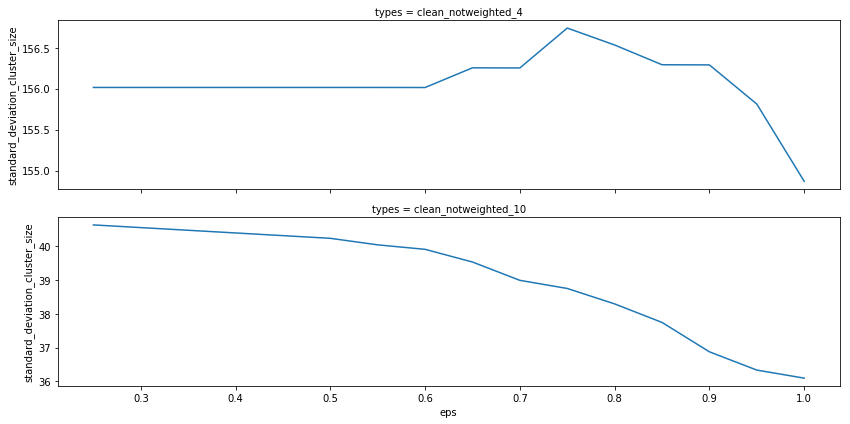

In [14]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=1, sharex=True, sharey=False, aspect=4.0, despine=False)
g = g.map(plt.plot, "eps", "standard_deviation_cluster_size")


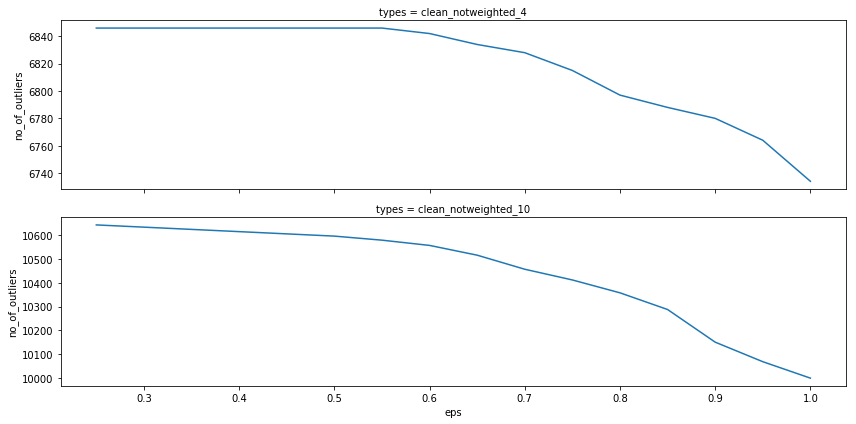

In [15]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=1, sharex=True, sharey=False, aspect=4.0, despine=False)
g = g.map(plt.plot, "eps", "no_of_outliers")

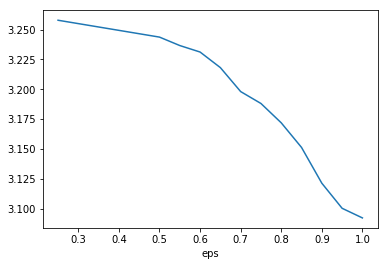

In [23]:
evaluation_df.loc["10", "position_entropy"].plot()

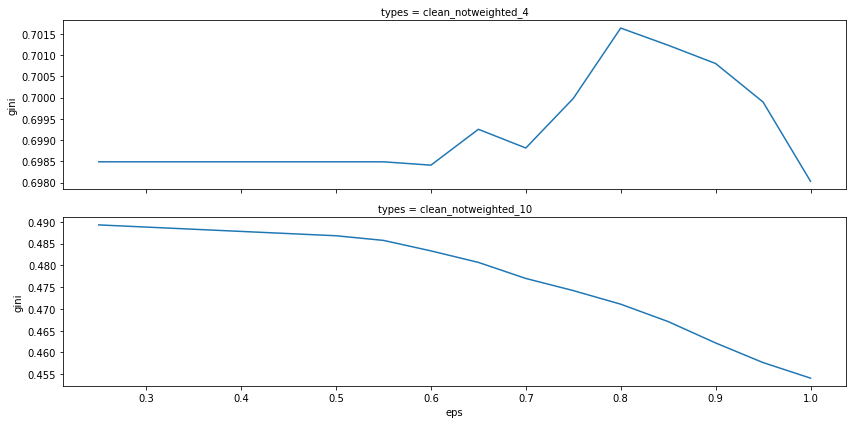

In [17]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=1, sharex=True, sharey=False, aspect=4.0, despine=False)
g = g.map(plt.plot, "eps", "gini")

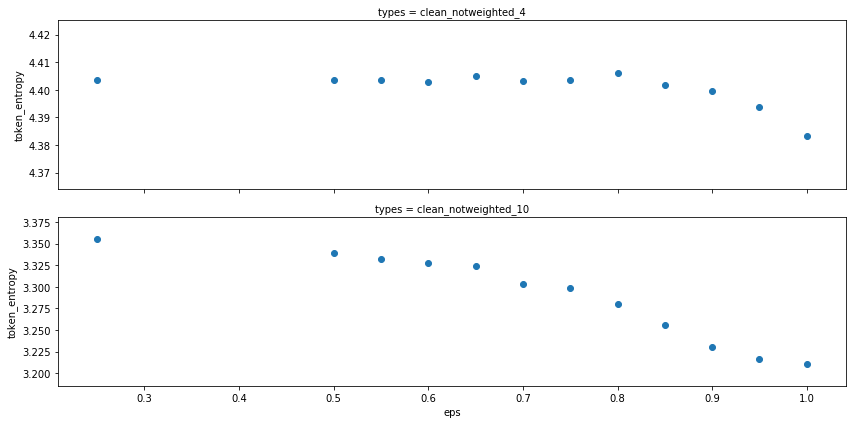

In [18]:

g = sns.FacetGrid(evaluation_df.reset_index(), col="types",col_wrap=1, sharex=True, sharey=False, aspect=4, despine=False)
g = g.map(plt.scatter,  "eps", "token_entropy")

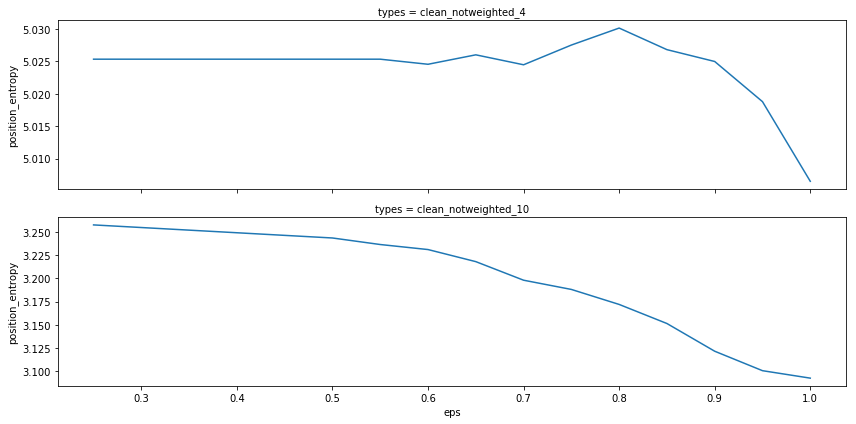

In [19]:

g = sns.FacetGrid(evaluation_df.reset_index(), col="types",col_wrap=1, sharex=True, sharey=False, aspect=4, despine=False)
g = g.map(plt.plot,  "eps", "position_entropy")

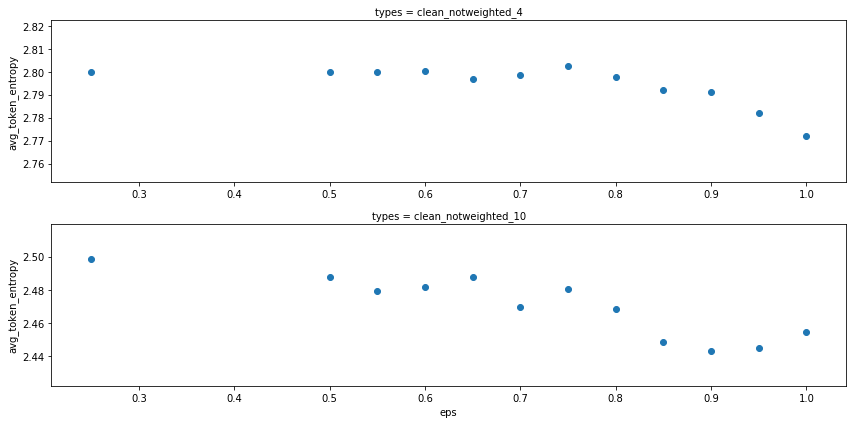

In [20]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=1, sharex=False, sharey=False, aspect=4, despine=False)
g = g.map(plt.scatter,  "eps", "avg_token_entropy")

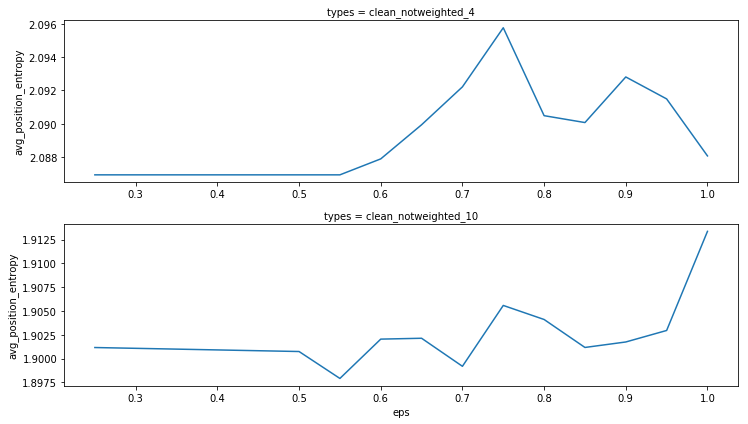

In [21]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=1, sharex=False, sharey=False, aspect=3.5, despine=False)
g = g.map(plt.plot,  "eps", "avg_position_entropy")
